In [ ]:
!pip install feature_engine
!pip install catboost
!pip install mrmr_selection


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import xgboost as xgb
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier


# Download Data

In [3]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"anismehmahi","key":"b4573c0e6c27b4d90cbb9b1d1a98c5f0"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c lcbm-challenge-haick-2022

 73% 9.00M/12.3M [00:00<00:00, 18.2MB/s]
100% 12.3M/12.3M [00:00<00:00, 23.6MB/s]


In [6]:
! mkdir lcbm-challenge-haick

In [7]:
! unzip /content/lcbm-challenge-haick-2022.zip -d /content/lcbm-challenge-haick

Archive:  /content/lcbm-challenge-haick-2022.zip
  inflating: /content/lcbm-challenge-haick/sample_submission.csv  
  inflating: /content/lcbm-challenge-haick/test.csv  
  inflating: /content/lcbm-challenge-haick/train.csv  


---
# Read Data

In [55]:
df = pd.read_csv("/content/lcbm-challenge-haick/train.csv")

In [56]:
final = pd.read_csv("/content/lcbm-challenge-haick/test.csv")

# Splitting Data

In [57]:
# Let's separate into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(
    df[df.columns.difference(['Classification traget'])], 
    df["Classification traget"], # target
    test_size=0.00001,  # percentage of obs in test set
    shuffle=True
    )  # seed to ensure reproducibility


In [58]:
var = [col for col in X_train.columns if X_train[col].isnull().sum()!=0 ]
len(var)

0

In [59]:
X_test

,AAC,AMW,AROM,ARR,ASP,ATS2s,ATS8m,ATS8s,ATSC1e,ATSC1m,...,nSO2N,nSO3,nTB,nThiazoles,nThioethanes,nThiophenes,nTriazoles,nX,piPC08,piPC10
1609,1.751,9.33,0.948,0.697,0.56,5.667,3.877,5.721,0.125,5.305,...,0,0,1,0,0,0,0,2,7.041,7.788


# Splitting + removing some colums

In [60]:
len(X_train.columns)

1419

In [61]:
cat_var = [col for col in X_train.columns if X_train[col].dtypes=='O'] 
len(cat_var)

2

In [62]:
num_var = [col for col in X_train.columns if X_train[col].dtypes!='O'] 
len(num_var)

1417

In [63]:
cat_var

['NAME', 'Status']

In [64]:
def split_name(x):
  var = str(x).split(' ')
  return int(var[1])

In [65]:
X_train['NAME']=X_train['NAME'].apply(lambda x: split_name(x))
X_test['NAME']=X_test['NAME'].apply(lambda x: split_name(x))
final['NAME']=final['NAME'].apply(lambda x: split_name(x))

In [66]:
X_train.drop(columns=['Status'],inplace=True)
X_test.drop(columns=['Status'],inplace=True)
final.drop(columns=['Status'],inplace=True)

In [67]:
X_train.drop(columns=['Molecule id'],inplace=True)
X_test.drop(columns=['Molecule id'],inplace=True)
final.drop(columns=['Molecule id'],inplace=True)

# Feature Selection

## Constant

In [ ]:
from feature_engine.selection import DropConstantFeatures

sel = DropConstantFeatures(tol=1, variables=None, missing_values='raise')
sel.fit(X_train)
len(sel.features_to_drop_)

0

In [ ]:
sel.features_to_drop_

['B03[S-Br]',
 'B06[O-B]',
 'B07[O-P]',
 'CATS2D_01_NL',
 'I-096',
 'T(S..I)',
 'nC=O(O)2',
 'nR=CHX']

In [ ]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
final = sel.transform(final)


## Quasi-constant (98% constant)

In [68]:
from feature_engine.selection import DropConstantFeatures,DropDuplicateFeatures
sel = DropConstantFeatures(tol=0.98, variables=None, missing_values='raise')
sel.fit(X_train)


DropConstantFeatures(tol=0.98)

In [69]:
len(sel.features_to_drop_)

285

In [70]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
final = sel.transform(final)


## Smart Correlation according to Model Performance

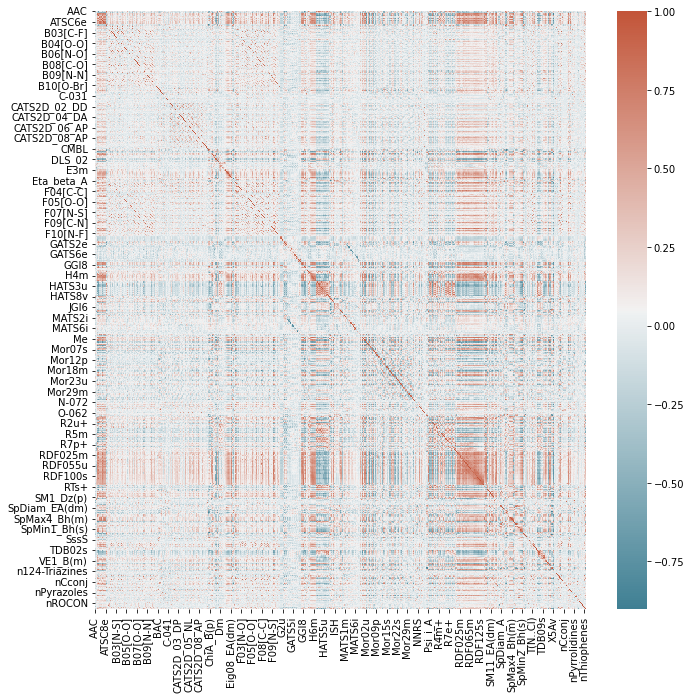

In [71]:
import seaborn as sns

# visualise correlated features:

# I will build a correlation matrix, which examines the 
# correlation of all features (that is, for all possible feature combinations)
# and then visualise the correlation matrix using a heatmap

# the default correlation method of pandas.corr is pearson
# I include it anyways for the demo
corrmat = X_train.corr(method='pearson')

# we can make a heatmap with the package seaborn
# and customise the colours of searborn's heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(11,11)

# and now plot the correlation matrix
sns.heatmap(corrmat, cmap=cmap)

In [72]:
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
rf = CatBoostClassifier(silent=True,task_type="GPU",
                           devices='0:1', learning_rate= 0.03, iterations= 100, depth= 10)
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.8,
    missing_values="raise",
    selection_method="model_performance",
    estimator=rf,
    scoring="accuracy",
    cv=5,
)

sel.fit(X_train, y_train)


SmartCorrelatedSelection(cv=5,
                         estimator=<catboost.core.CatBoostClassifier object at 0x7f61c03f9490>,
                         missing_values='raise', scoring='accuracy',
                         selection_method='model_performance')

In [73]:
sel.correlated_feature_sets_


[{'AAC', 'Me'},
 {'AMW', 'AVS_B(m)', 'GATS1m', 'H%', 'HATS2m', 'Mp', 'SpPosA_B(m)', 'TDB08m'},
 {'ARR', 'SpMAD_EA(bo)'},
 {'ASP', 'L/Bw'},
 {'ATS2s',
  'ATS8s',
  'ATSC5e',
  'ChiA_D/Dt',
  'DBI',
  'DELS',
  'Eta_FL',
  'GGI1',
  'GGI10',
  'H5s',
  'MSD',
  'MW',
  'Mor02m',
  'Mor02s',
  'RDF025s',
  'Ram',
  'SM03_EA(bo)',
  'SM12_AEA(bo)',
  'SM15_AEA(ri)',
  'SM1_Dz(p)',
  'SPI',
  'SpMax7_Bh(s)',
  'Xt',
  'nHet'},
 {'ATS8m', 'HATS0u', 'RTv', 'SpMax5_Bh(m)'},
 {'ATSC1m', 'ATSC3m', 'Mor02u', 'RDF040u', 'RDF090u', 'SpDiam_RG', 'nCsp3'},
 {'ATSC1s', 'ATSC4s'},
 {'ATSC2e', 'ATSC2s', 'ATSC6e', 'ATSC7e', 'ATSC8e', 'Mor03s'},
 {'ATSC3e', 'ATSC3s'},
 {'ATSC5m', 'Eta_C_A', 'RDF025m', 'RDF045u', 'RDF050u', 'X5v'},
 {'ATSC5s', 'ATSC6s'},
 {'ATSC7s', 'ATSC8s'},
 {'AVS_B(e)', 'AVS_B(p)', 'ChiA_B(e)', 'ChiA_B(p)'},
 {'B01[C-O]',
  'B02[C-O]',
  'B03[C-O]',
  'B04[C-O]',
  'B05[C-O]',
  'B06[C-O]',
  'B08[C-O]'},
 {'B02[C-S]', 'B03[C-S]', 'B07[C-S]', 'F02[C-S]', 'nS'},
 {'B02[O-O]', 'F02[O-O]'

In [74]:
len(sel.features_to_drop_)

355

In [75]:
X_train=sel.transform(X_train)
X_test=sel.transform(X_test)
final=sel.transform(final)


In [77]:
len(X_train.columns)


777

## Chi-square test

In [ ]:
from scipy.stats import chi2_contingency
chi_ls = []

for feature in X_train.columns:
    
    # create contingency table
    c = pd.crosstab(y_train, X_train[feature])
    
    # chi_test
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)


Text(0.5, 1.0, 'Feature importance based on chi-square test')

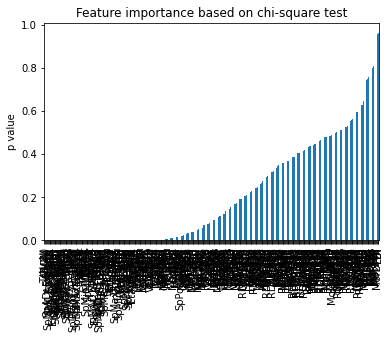

In [ ]:
pd.Series(chi_ls, index=X_train.columns).sort_values(ascending=True).plot.bar(rot=90)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')


In [ ]:
var = pd.Series(chi_ls, index=X_train.columns).sort_values(ascending=True)


In [ ]:
cc = var[var<0.1]

In [ ]:
selected = cc.index
selected


Index(['T(N..N)', 'CMBL', 'AROM', 'SpAD_EA(dm)', 'SpMax_AEA(dm)',
       'SM12_AEA(ri)', 'F08[C-N]', 'SpMax_L', 'ARR', 'Eig02_AEA(dm)',
       ...
       'R4s+', 'VE1_RG', 'H3u', 'R3s+', 'Mor22m', 'Mor30u', 'GATS5s', 'Mor06p',
       'HATS5u', 'TDB02s'],
      dtype='object', length=205)

In [ ]:
X_train.drop(inplace=True,columns=X_train.columns.difference(selected))
X_test.drop(inplace=True,columns = X_test.columns.difference(selected))
final.drop(inplace=True,columns = final.columns.difference(selected))


## Anova test

In [24]:
from sklearn.feature_selection import f_classif, f_regression

# to select features
from sklearn.feature_selection import SelectKBest, SelectPercentile


In [25]:
univariate = f_classif(X_train, y_train)
univariate


(array([3.25452094e+01, 5.85701263e-01, 6.08624506e-03, ...,
        1.03047054e+02, 2.42815036e+02, 2.10909978e+02]),
 array([1.22872417e-08, 4.44120897e-01, 9.37819601e-01, ...,
        5.46366316e-24, 1.52099826e-53, 7.08456833e-47]))

In [26]:
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns


In [27]:
# select the top 18 features
sel_ = SelectPercentile(f_classif, percentile=60).fit(X_train, y_train)
# display selected feature names
columns = X_train.columns[sel_.get_support()]

In [28]:
X_train = X_train[columns]
X_test = X_test[columns]
final = final[columns]

In [29]:
X_train

,AAC,ATS2s,ATS8m,ATS8s,ATSC1m,ATSC2e,ATSC3e,ATSC3m,ATSC3s,ATSC5e,...,nRCONHR,nRNR2,nROCON,nROR,nRSR,nTB,nThiophenes,nX,piPC08,piPC10
861,1.719,5.984,4.338,6.074,13.738,0.389,0.547,44.357,48.905,0.808,...,0,1,0,0,0,0,0,2,7.545,8.354
460,1.694,5.681,3.828,5.646,7.052,0.268,0.509,21.556,48.913,0.473,...,1,0,0,0,0,0,0,1,7.297,7.916
2481,1.751,5.730,3.942,6.070,7.990,0.458,0.651,20.721,61.228,0.718,...,1,0,0,1,0,1,0,1,7.427,8.064
597,1.665,5.658,4.163,5.757,8.351,0.310,0.429,33.763,33.032,0.579,...,0,0,0,1,0,0,0,1,7.928,8.692
3729,1.685,5.613,3.981,6.006,7.131,0.240,0.376,22.400,54.187,0.432,...,0,0,0,0,0,0,0,2,6.029,6.543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,1.553,5.787,4.083,6.271,7.153,0.314,0.427,18.407,70.517,0.765,...,0,0,0,0,0,0,0,0,6.501,7.243
2771,1.628,5.954,4.406,6.321,13.511,0.337,0.501,37.298,55.086,0.675,...,1,0,0,0,0,1,0,1,7.731,8.415
4676,1.618,5.334,2.735,4.989,4.609,0.116,0.313,11.631,48.489,0.317,...,0,0,0,0,0,0,0,0,6.689,7.263
2330,1.576,5.953,4.257,6.321,14.306,0.416,0.513,34.544,46.906,0.696,...,1,1,0,0,0,0,0,0,7.269,7.919


## MRMR

In [30]:
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X_train, y=y_train, K=120)

100%|██████████| 120/120 [00:50<00:00,  2.39it/s]


In [31]:
X_train=X_train[selected_features]
X_test=X_test[selected_features]
final=final[selected_features]

# Scaling 

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

final = scaler.transform(final)


In [33]:
len(X_train.columns)

AttributeError: ignored

# Modeling

In [79]:
X_train.columns = X_train.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
X_test.columns = X_test.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
final.columns = final.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [80]:
#Model Selection
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


In [81]:
model_factory = [CatBoostClassifier(learning_rate=0.1, depth=3,silent=True), 
                 RandomForestClassifier( ),
                 xgb.XGBClassifier(), 

]
for model in model_factory:
    mf = model.fit(X_train, y_train)
    Pred = mf.predict(X_test)
    scores=cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(model.__class__.__name__, " : Train Accuracy: ", accuracy_score(y_test, Pred), " : Validation Accuracy : ", np.mean(scores))

CatBoostClassifier  : Train Accuracy:  1.0  : Validation Accuracy :  0.8294972607806731
RandomForestClassifier  : Train Accuracy:  1.0  : Validation Accuracy :  0.8298800337870789
XGBClassifier  : Train Accuracy:  1.0  : Validation Accuracy :  0.7947834296093322


### Tunig RF

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
RandomForestModel = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (RandomForestModel.best_score_, RandomForestModel.best_params_))


Best: 0.829255 using {'max_features': 'sqrt', 'n_estimators': 1000}


In [ ]:
RandomForestModel = RandomForestClassifier(max_features= 'sqrt',n_estimators= 1000,)
RandomForestModel.fit(X_train,y_train)
RandomForestModel.score(X_test,y_test)

1.0

### Tuning CatBoostClassifier Parameters

In [3]:
parameters = {'depth'         : [ 10,15],
                 'learning_rate' : [0.03,0.35,0.04],
                  'iterations'    : [ 100,150]}


gs = RandomizedSearchCV(CatBoostClassifier(silent=True,task_type="GPU",
                           devices='0:1'), parameters,n_iter = 60,refit=True, scoring='accuracy', cv=3, verbose=1, )
gs.fit(X_train, y_train)

NameError: ignored

In [ ]:
gs.best_estimator_
cata = gs.best_estimator_
cata.fit(X_train, y_train)
cross_val_score(cata, X_train, y_train, cv=3, scoring='accuracy')

1.0

In [ ]:
gs.best_params_

{'learning_rate': 0.03, 'iterations': 100, 'depth': 10}

### Voting

In [ ]:
estimators = [('cat', cata),('rf',RandomForestModel)]
vt = VotingClassifier(estimators, voting='soft')
vt.fit(X_train, y_train)

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x7f0f0b5d21d0>),
                             ('rf',
                              RandomForestClassifier(max_features='sqrt',
                                                     n_estimators=1000))],
                 voting='soft')

In [ ]:
vt.score(X_test,y_test)

1.0

In [ ]:
import pickle
filename = '/content/voting.sav'
pickle.dump(vt, open(filename, 'wb'))

# Predicting

In [ ]:
result = vt.predict(final)
result

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
pd.DataFrame(result).value_counts()

1    875
0    863
dtype: int64

In [ ]:
submission = pd.read_csv("/content/lcbm-challenge-haick/sample_submission.csv")

In [ ]:
submission['Classification traget'] = result

In [ ]:
submission.to_csv('/content/lcbm-challenge-haick/2.csv',index=False)
submission

,Molecule id,Classification traget
0,700,1
1,1156,0
2,236,1
3,867,0
4,1593,0
...,...,...
1733,1399,0
1734,1608,0
1735,607,1
1736,643,1


# chkopi

In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
import xgboost as xgb


# Put models in a dictionary
models = {
          "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0),
          "Random Forest": RandomForestClassifier(),
          "CatBoost":CatBoostClassifier(eval_metric='Accuracy', silent=True),
          "Xgboost": xgb.XGBClassifier(),
          "KNN": KNeighborsClassifier(),
          "Linear SVC":svm.SVC() 
            }

# Create a function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [ ]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]
final.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in final.columns.values]

model_scores = fit_and_score(models=models,
                             x_train=X_train,
                             x_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'CatBoost': 1.0,
 'Gradient Boosting Classifier': 1.0,
 'KNN': 1.0,
 'Linear SVC': 1.0,
 'Random Forest': 1.0,
 'Xgboost': 1.0}

In [ ]:
models['Random Forest'].predict(final)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
X_test

array([[-0.99167245, -1.17438234,  0.41902696, ..., -0.96792649,
         1.25021417,  0.90935589],
       [ 0.51637095, -0.13090303,  0.30873553, ..., -0.96792649,
         0.38972717,  0.12850937],
       [-0.59186559, -0.24887746,  0.86019269, ..., -0.96792649,
        -1.02367607, -0.49958468],
       ...,
       [ 0.66366821, -0.47110838,  0.48029998, ...,  0.99474147,
         0.38439357,  0.30739055],
       [ 0.18670565, -0.54427082,  0.40677236, ...,  1.97607544,
         0.03415403, -0.0121837 ],
       [ 0.26386136,  0.69674708,  0.40677236, ...,  0.01340749,
         1.18087741,  0.85006382]])